# Environment Installation

In [1]:
!pip install albumentations --user

The directory '/home/jovyan/.cache/pip/http' or its parent directory is not owned by the current user and the cache has been disabled. Please check the permissions and owner of that directory. If executing pip with sudo, you may want sudo's -H flag.
The directory '/home/jovyan/.cache/pip' or its parent directory is not owned by the current user and caching wheels has been disabled. check the permissions and owner of that directory. If executing pip with sudo, you may want sudo's -H flag.


In [2]:
!pip install pretrainedmodels --user

The directory '/home/jovyan/.cache/pip/http' or its parent directory is not owned by the current user and the cache has been disabled. Please check the permissions and owner of that directory. If executing pip with sudo, you may want sudo's -H flag.
The directory '/home/jovyan/.cache/pip' or its parent directory is not owned by the current user and caching wheels has been disabled. check the permissions and owner of that directory. If executing pip with sudo, you may want sudo's -H flag.


In [12]:
import os
import cv2
import csv
import time 
import tqdm
import torch
import warnings
import numpy as np 
import torchvision
import pandas as pd 
train_on_gpu = True
from PIL import Image
import torch.nn as nn
import albumentations
import pretrainedmodels
import torch.optim as optim
from torchvision import models
from keras.models import Model
import matplotlib.pyplot as plt
import torch.nn.functional as F
import matplotlib.image as mplimg
from collections import OrderedDict
from torch.optim import lr_scheduler
from matplotlib.pyplot import imshow
from albumentations import torch as AT
import torchvision.transforms as transforms
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from keras.layers import Dense, GlobalAveragePooling2D
from torch.utils.data.sampler import SubsetRandomSampler
warnings.simplefilter("ignore", category=DeprecationWarning)
from torch.utils.data import TensorDataset, DataLoader,Dataset
from keras.applications.densenet import DenseNet201,preprocess_input
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, CosineAnnealingLR

Using TensorFlow backend.


In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


# Prepare data

In [9]:
train_df = pd.read_csv("../data/train.csv")
test_df = pd.read_csv("../data/new_whale_test.csv")
train_df.head()

FileNotFoundError: File b'../data/train.csv' does not exist

In [8]:
print(f"There are {len(os.listdir('../data/train'))} images in train dataset with {train_df.Id.nunique()} unique classes.")
print(f"There are {len(os.listdir('../data/test'))} images in test dataset with {test_df.Id.nunique()} unique classes.")
    

There are 20288 images in train dataset with 4571 unique classes.
There are 5074 images in test dataset with 1522 unique classes.


In [9]:
for i in range(1, 4):
    print(f'There are {train_df.Id.value_counts()[train_df.Id.value_counts().values==i].shape[0]} classes with {i} samples in train data.')
    

There are 2182 classes with 1 samples in train data.
There are 1085 classes with 2 samples in train data.
There are 441 classes with 3 samples in train data.


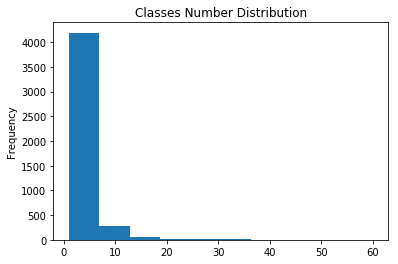

In [10]:
train_df.Id.value_counts()[1:].plot(kind='hist');
plt.title('Classes Number Distribution');

In [15]:
def prepare_labels(y):
    # From here: https://www.kaggle.com/pestipeti/keras-cnn-starter
    values = np.array(y)
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(values)
    onehot_encoder = OneHotEncoder(sparse=False)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
    y = onehot_encoded
    return y, label_encoder

y, le = prepare_labels(train_df['Id'])
y_ts, le_ts = prepare_labels(test_df['Id'])

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a Lab

# Prepare Network

### Simple CNN

In [15]:
class WhaleDataset(Dataset):
    def __init__(self, datafolder, datatype='train', df=None, transform = transforms.Compose([transforms.ToTensor()]), y=None):
        self.datafolder = datafolder
        self.datatype = datatype
        self.y = y
        if self.datatype == 'train':
            self.df = df.values
        self.image_files_list = [s for s in os.listdir(datafolder)]
        self.transform = transform


    def __len__(self):
        return len(self.image_files_list)
    
    def __getitem__(self, idx):
        if self.datatype == 'train':
            img_name = os.path.join(self.datafolder, self.df[idx - 1][0])
            label = self.y[idx - 1]
            
        elif self.datatype == 'test':
            img_name = os.path.join(self.datafolder, self.image_files_list[idx - 1])
            label = np.zeros((4571,))

        image = Image.open(img_name).convert('RGB')
        image = self.transform(image)
        if self.datatype == 'train':
            return image, label
        elif self.datatype == 'test':
            # so that the images will be in a correct order
            return image, label, self.image_files_list[idx]
        

In [16]:
data_transforms = transforms.Compose([
                                      transforms.Resize((100, 100)),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                             std=[0.229, 0.224, 0.225])
    ])
data_transforms_test = transforms.Compose([
                                           transforms.Resize((100, 100)),
                                           transforms.ToTensor(),
                                           transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                                 std=[0.229, 0.224, 0.225])
])


In [17]:
train_dataset = WhaleDataset(datafolder='../data/train/', datatype='train', df=train_df, transform=data_transforms, y=y)
test_set = WhaleDataset(datafolder='../data/test/', datatype='test', transform=data_transforms_test)

train_sampler = SubsetRandomSampler(list(range(len(os.listdir('../data/train')))))
valid_sampler = SubsetRandomSampler(list(range(len(os.listdir('../data/test')))))
batch_size = 128
num_workers = 0

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=32, num_workers=num_workers)


In [181]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 7, padding=1)
        self.conv2_bn = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(2, 2)
        
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)        
        self.pool2 = nn.AvgPool2d(3, 3)
        
        self.fc1 = nn.Linear(64 * 4 * 4 * 16, 1024)
        self.fc2 = nn.Linear(1024, 4571) # todo

        self.dropout = nn.Dropout(0.5)        

    def forward(self, x):
        x = self.pool(F.relu(self.conv2_bn(self.conv1(x))))
        x = self.pool2(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 4 * 4 * 16)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x

In [182]:
model_conv = Net()
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model_conv.parameters(), lr=0.01)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# Resnet 18

In [20]:
class WhaleDataset(Dataset):
    def __init__(self, datafolder, datatype='train', df=None, transform = transforms.Compose([transforms.ToTensor()]), y=None):
        self.datafolder = datafolder
        self.datatype = datatype
        self.y = y
        if self.datatype == 'train':
            self.df = df.values
        self.image_files_list = [s for s in os.listdir(datafolder)]
        self.transform = transform


    def __len__(self):
        return len(self.image_files_list)
    
    def __getitem__(self, idx):
        if self.datatype == 'train':
            img_name = os.path.join(self.datafolder, self.df[idx - 1][0])
            label = self.y[idx - 1]
            
        elif self.datatype == 'test':
            img_name = os.path.join(self.datafolder, self.image_files_list[idx - 1])
            label = np.zeros((4571,))

        image = Image.open(img_name).convert('RGB')
        image = self.transform(image)
        if self.datatype == 'train':
            return image, label
        elif self.datatype == 'test':
            # so that the images will be in a correct order
            return image, label, self.image_files_list[idx]
        

In [21]:
data_transforms = transforms.Compose([
                                      transforms.RandomResizedCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                             std=[0.229, 0.224, 0.225])
    ])
data_transforms_test = transforms.Compose([
                                           transforms.RandomResizedCrop(224),
                                           transforms.ToTensor(),
                                           transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                                 std=[0.229, 0.224, 0.225])
])


In [22]:
train_dataset = WhaleDataset(datafolder='../data/train/', datatype='train', df=train_df, transform=data_transforms, y=y)
test_set = WhaleDataset(datafolder='../data/test/', datatype='test', transform=data_transforms_test)

train_sampler = SubsetRandomSampler(list(range(len(os.listdir('../data/train')))))
valid_sampler = SubsetRandomSampler(list(range(len(os.listdir('../data/test')))))
batch_size = 32
num_workers = 0

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=32, num_workers=num_workers)


In [118]:
num_classes = 4571
model_conv = models.resnet18(pretrained=True)
num_ftrs = model_conv.fc.in_features 
model_conv.fc = nn.Linear(num_ftrs, num_classes) #NUM_CLASSES needs to be changed
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model_conv.parameters(), lr=0.01)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)


# Resnet 101

In [ ]:
class WhaleDataset(Dataset):
    def __init__(self, datafolder, datatype='train', df=None, transform = transforms.Compose([transforms.ToTensor()]), y=None):
        self.datafolder = datafolder
        self.datatype = datatype
        self.y = y
        if self.datatype == 'train':
            self.df = df.values
        self.image_files_list = [s for s in os.listdir(datafolder)]
        self.transform = transform

    def __len__(self):
        return len(self.image_files_list)
    
    def __getitem__(self, idx):
        if self.datatype == 'train':
            img_name = os.path.join(self.datafolder, self.df[idx - 1][0])
            label = self.y[idx - 1]
            
        elif self.datatype == 'test':
            img_name = os.path.join(self.datafolder, self.image_files_list[idx - 1])
            label = np.zeros((4571,))

        img = cv2.imread(img_name)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        image = self.transform(image=img)
        image = image['image']
        if self.datatype == 'train':
            return image, label
        elif self.datatype == 'test':
            # so that the images will be in a correct order
            return image, label, self.image_files_list[idx]
        

In [ ]:
data_transforms = albumentations.Compose([
    albumentations.Resize(160, 320),
    albumentations.HorizontalFlip(),
    albumentations.RandomBrightness(),
    albumentations.ShiftScaleRotate(rotate_limit=15, scale_limit=0.10),
    albumentations.JpegCompression(80),
    albumentations.HueSaturationValue(),
    albumentations.Normalize(),
    AT.ToTensor()
    ])
data_transforms_test = albumentations.Compose([
    albumentations.Resize(160, 320),
    albumentations.Normalize(),
    AT.ToTensor()
    ])

train_dataset = WhaleDataset(datafolder='../data/train/', datatype='train', df=train_df, transform=data_transforms, y=y)
test_set = WhaleDataset(datafolder='../data/test/', datatype='test', transform=data_transforms_test)

train_sampler = SubsetRandomSampler(list(range(len(os.listdir('../data/train')))))
valid_sampler = SubsetRandomSampler(list(range(len(os.listdir('../data/test')))))
batch_size = 10
num_workers = 0
# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, num_workers=num_workers)
#valid_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=10, num_workers=num_workers)


In [ ]:
model_conv = pretrainedmodels.resnext101_64x4d()
model_conv.avg_pool = nn.AvgPool2d((5,10))
model_conv.last_linear = nn.Linear(model_conv.last_linear.in_features, 4571)


model_conv.cuda()
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model_conv.parameters(), lr=0.01)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# Train

### Every model use the same one

In [159]:
model_conv.cuda()
n_epochs = 3
acc = [0] * (n_epochs + 1)
total = list(0. for i in range(train_df.Id.nunique()))
correct = list(0. for i in range(train_df.Id.nunique()))
llloss = [0] * (n_epochs + 1)

for epoch in range(1, n_epochs+1):
    print(time.ctime(), 'Epoch:', epoch)

    train_loss = []
    valid_loss = []
    exp_lr_scheduler.step()
    accuracy = []
    
    # train
    for batch_i, (data, target) in enumerate(train_loader):
        #print(batch_i)
        data, target = data.cuda(), target.cuda()

        optimizer.zero_grad()
        output = model_conv(data)
        predicted = torch.argmax(output, 1)

        res = (predicted == torch.argmax(target, 1)).squeeze()
        
        for label_idx in range(len(target)):
            
            label_single = torch.argmax(target, 1)[label_idx]
            correct[label_single] += res[label_idx].item()
            total[label_single] += 1
        
        loss = criterion(output, target.float())
        train_loss.append(loss.item())
        loss.backward()
        optimizer.step()
          
    llloss[epoch] = np.mean(train_loss)
    acc[epoch] = sum(correct)/sum(total)
    print(f'Epoch {epoch}, train loss: {llloss[epoch]}, acc : {acc[epoch]}')
    
acc_base_train = acc
loss_base_train = llloss

Sat Jun  8 15:39:55 2019 Epoch: 1
Epoch 1, train loss: 0.0015707067524642028, acc : 0.38091482649842273
Sat Jun  8 17:00:44 2019 Epoch: 2
Epoch 2, train loss: 0.0014676046662148274, acc : 0.38091482649842273
Sat Jun  8 18:24:24 2019 Epoch: 3


KeyboardInterrupt: 

In [160]:
net_name = 'Transfer_learning'

In [161]:
torch.save(model_conv.state_dict(), net_name + '.pth')
#model_conv.load_state_dict(torch.load(net_name + '.pth'))

### Plot

In [162]:
acc_base_train = acc
loss_base_train = llloss

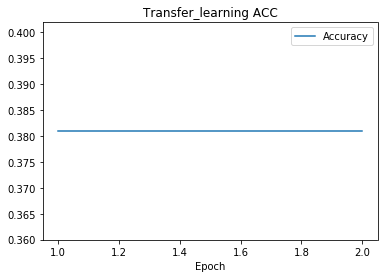

In [163]:
n_epochs = 2
epoch = range(1, n_epochs + 1)
plt.plot(epoch, acc_base_train[1:n_epochs + 1], label = 'Accuracy')

plt.xlabel('Epoch')
plt.title(net_name + ' ACC')
plt.legend()
plt.savefig(f'../result/{net_name}_ACC_{time.ctime()}.jpg')#,dpi = 900)
plt.show()

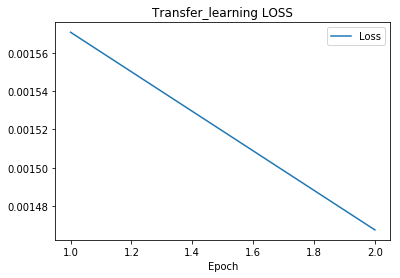

In [164]:
plt.plot(epoch, loss_base_train[1:n_epochs + 1], label = 'Loss')
plt.xlabel('Epoch')
plt.title(net_name + ' LOSS')
plt.legend()
plt.savefig(f'../result/{net_name}_LOSS_{time.ctime()}.jpg')#,dpi = 900)
plt.show()

# get the augmentated images

In [ ]:
import matplotlib

for batch_i, (data, target) in enumerate(train_loader):
    da = data.cpu().numpy()[-1][-1]
    print(da.shape)
    matplotlib.image.imsave('../pic/' + str(batch_i) + '.png', da)

# CNN Extraction

In [3]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
import matplotlib.image as mplimg
from matplotlib.pyplot import imshow

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

import torch
from torch.utils.data import TensorDataset, DataLoader,Dataset
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torch.optim import lr_scheduler
import time 
import tqdm
from PIL import Image
train_on_gpu = True
from torch.utils.data.sampler import SubsetRandomSampler
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, CosineAnnealingLR

import warnings
warnings.simplefilter("ignore", category=DeprecationWarning)

from collections import OrderedDict
import cv2
import albumentations
from albumentations import torch as AT
import pretrainedmodels
import csv
from sklearn.neighbors import KNeighborsClassifier
from torch.autograd import Variable
from torchvision.utils import save_image
from sklearn.externals import joblib
from sklearn.svm import LinearSVC
from torchvision import models

In [4]:
class WhaleDataset(Dataset):
    def __init__(self, datafolder, datatype='train', df=None, transform = transforms.Compose([transforms.ToTensor()]), y=None):
        self.datafolder = datafolder
        self.datatype = datatype
        self.y = y
        if self.datatype == 'train':
            self.df = df.values
        self.image_files_list = [s for s in os.listdir(datafolder)]
        self.transform = transform


    def __len__(self):
        return len(self.image_files_list)
    
    def __getitem__(self, idx):
        if self.datatype == 'train':
            img_name = os.path.join(self.datafolder, self.df[idx - 1][0])
            label = self.y[idx - 1]
            
        elif self.datatype == 'test':
            img_name = os.path.join(self.datafolder, self.image_files_list[idx - 1])
            label = np.zeros((4571,))

        image = Image.open(img_name).convert('RGB')
        image = self.transform(image)
        if self.datatype == 'train':
            return image, label
        elif self.datatype == 'test':
            # so that the images will be in a correct order
            return image, label, self.image_files_list[idx]

In [5]:
data_transforms = transforms.Compose([
                                      transforms.Resize((100, 100)),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                             std=[0.229, 0.224, 0.225])
    ])
data_transforms_test = transforms.Compose([
                                           transforms.Resize((100, 100)),
                                           transforms.ToTensor(),
                                           transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                                 std=[0.229, 0.224, 0.225])
])


In [16]:
train_dataset = WhaleDataset(datafolder='./whaletrain/', datatype='train', df=train_df, transform=data_transforms, y=y)
test_set = WhaleDataset(datafolder='./whaletest/', datatype='train', df=test_df, transform=data_transforms_test,y = y_ts)

train_sampler = SubsetRandomSampler(list(range(len(train_df))))#len(os.listdir('./whaletrain')))))
valid_sampler = SubsetRandomSampler(list(range(len(train_df))))#len(os.listdir('./whaletrain')))))
batch_size = 32
num_workers = 0

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, num_workers=num_workers)
# less size for test loader.
test_loader = torch.utils.data.DataLoader(test_set, batch_size=32, num_workers=num_workers)


In [17]:
class Net_ext(nn.Module):
    def __init__(self, num_classes):
        super(Net_ext, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 7, padding=1)
        self.conv2_bn = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(2, 2)
        
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)        
        self.pool2 = nn.AvgPool2d(3, 3)
        
        self.fc1 = nn.Linear(64 * 4 * 4 * 16, 1024)
        self.fc2 = nn.Linear(1024, num_classes)

        self.dropout = nn.Dropout(0.5)        

    def forward(self, x):
        x = self.pool(F.relu(self.conv2_bn(self.conv1(x))))
        x = self.pool2(F.relu(self.conv2(x)))
#         x = x.view(-1, 64 * 4 * 4 * 16)
#         x = F.relu(self.fc1(x))
#         x = self.dropout(x)
#         x = self.fc2(x)

        return x

In [19]:
model_conv_ext = Net_ext(4571)
model_conv_ext.load_state_dict(torch.load('./model/simplecnn.pkl'))

## Extraction

In [20]:
ext_1 = []
ext_2 = []
#for (data, target, name) in train_loader:
for batch_i, (data, target) in enumerate(train_loader):
    print(f'exctrating data in batch{batch_i}')
    data = data.cuda()
    model_conv_ext.cuda()
    output = model_conv_ext(data)
    for i in range(len(output)):
        ext_1.append((output[i].cpu().detach().numpy(),target[i]))
        ext_2.append((data[i].cpu().detach().numpy(),target[i]))

exctrating data in batch0
exctrating data in batch1
exctrating data in batch2
exctrating data in batch3
exctrating data in batch4
exctrating data in batch5
exctrating data in batch6
exctrating data in batch7
exctrating data in batch8
exctrating data in batch9
exctrating data in batch10
exctrating data in batch11
exctrating data in batch12
exctrating data in batch13
exctrating data in batch14
exctrating data in batch15
exctrating data in batch16
exctrating data in batch17
exctrating data in batch18
exctrating data in batch19
exctrating data in batch20
exctrating data in batch21
exctrating data in batch22
exctrating data in batch23
exctrating data in batch24
exctrating data in batch25
exctrating data in batch26
exctrating data in batch27
exctrating data in batch28
exctrating data in batch29
exctrating data in batch30
exctrating data in batch31
exctrating data in batch32
exctrating data in batch33
exctrating data in batch34
exctrating data in batch35
exctrating data in batch36
exctrating 

exctrating data in batch297
exctrating data in batch298
exctrating data in batch299
exctrating data in batch300
exctrating data in batch301
exctrating data in batch302
exctrating data in batch303
exctrating data in batch304
exctrating data in batch305
exctrating data in batch306
exctrating data in batch307
exctrating data in batch308
exctrating data in batch309
exctrating data in batch310
exctrating data in batch311
exctrating data in batch312
exctrating data in batch313
exctrating data in batch314
exctrating data in batch315
exctrating data in batch316
exctrating data in batch317
exctrating data in batch318
exctrating data in batch319
exctrating data in batch320
exctrating data in batch321
exctrating data in batch322
exctrating data in batch323
exctrating data in batch324
exctrating data in batch325
exctrating data in batch326
exctrating data in batch327
exctrating data in batch328
exctrating data in batch329
exctrating data in batch330
exctrating data in batch331
exctrating data in b

exctrating data in batch590
exctrating data in batch591
exctrating data in batch592
exctrating data in batch593
exctrating data in batch594
exctrating data in batch595
exctrating data in batch596
exctrating data in batch597
exctrating data in batch598
exctrating data in batch599
exctrating data in batch600
exctrating data in batch601
exctrating data in batch602
exctrating data in batch603
exctrating data in batch604
exctrating data in batch605
exctrating data in batch606
exctrating data in batch607
exctrating data in batch608
exctrating data in batch609
exctrating data in batch610
exctrating data in batch611
exctrating data in batch612
exctrating data in batch613
exctrating data in batch614
exctrating data in batch615
exctrating data in batch616
exctrating data in batch617
exctrating data in batch618
exctrating data in batch619
exctrating data in batch620
exctrating data in batch621
exctrating data in batch622
exctrating data in batch623
exctrating data in batch624
exctrating data in b

In [21]:
test_ext_1 = []
test_ext_2 = []
#for (data, target, name) in train_loader:
for batch_i, (data, target) in enumerate(test_loader):
#     if batch_i == 20:
#         break
    print(f'exctrating data in batch{batch_i}')
    data = data.cuda()
    model_conv_ext.cuda()
    output = model_conv_ext(data)
    for i in range(len(output)):
        test_ext_1.append((output[i].cpu().detach().numpy(),target[i]))
        test_ext_2.append((data[i].cpu().detach().numpy(),target[i]))

exctrating data in batch0
exctrating data in batch1
exctrating data in batch2
exctrating data in batch3
exctrating data in batch4
exctrating data in batch5
exctrating data in batch6
exctrating data in batch7
exctrating data in batch8
exctrating data in batch9
exctrating data in batch10
exctrating data in batch11
exctrating data in batch12
exctrating data in batch13
exctrating data in batch14
exctrating data in batch15
exctrating data in batch16
exctrating data in batch17
exctrating data in batch18
exctrating data in batch19
exctrating data in batch20
exctrating data in batch21
exctrating data in batch22
exctrating data in batch23
exctrating data in batch24
exctrating data in batch25
exctrating data in batch26
exctrating data in batch27
exctrating data in batch28
exctrating data in batch29
exctrating data in batch30


IndexError: index 1015 is out of bounds for axis 0 with size 1015

### Show the feature

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


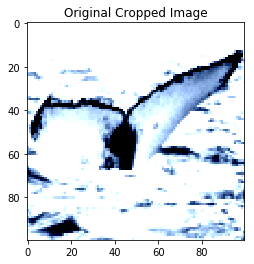

In [22]:
x = ext_2[2][0]
b = cv2.merge([x[0,:,:],x[1,:,:],x[2,:,:]])
plt.title('Original Cropped Image')
plt.imshow(b) 

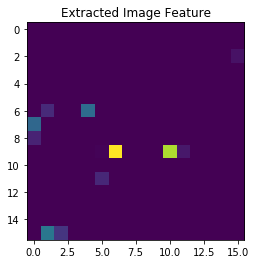

In [23]:
x = ext_1[2][0]
plt.title('Extracted Image Feature')
plt.imshow(x[6,:,:]) 

# Classification by Knn

In [ ]:
x = np.zeros((len(ext_2), 30000))
for i in range(len(ext_2)):
    x[i, :]= ext_2[i][0].reshape(1, 30000)
x_ts = np.zeros((len(test_ext_2), 30000))
for i in range(len(test_ext_2)):
    x[i, :]= test_ext_2[i][0].reshape(1, 30000)
y_n = np.argmax(y, axis = 1)
y_n_ts = np.argmax(y_ts, axis = 1)

In [ ]:
knn_conv_ori = KNeighborsClassifier(n_neighbors=3)
knn_conv_ori.fit(x, y_n)
joblib.dump(knn_conv_ori, "./model/knn_conv_ori.m")

In [ ]:
knn_conv_ori.score(x_ts, y_n_ts)

In [ ]:
x = np.zeros((len(ext_1), 16384))
y_n = np.zeros(len(ext_1))
for i in range(len(ext_1)):
    x[i, :]= ext_1[i][0].reshape(1, 16384)
    y_n[i] = np.argmax(ext_1[i][1].cpu().detach().numpy(), axis = 0)
x_ts = np.zeros((len(test_ext_1), 16384))
y_n_ts = np.zeros(len(test_ext_1))
for i in range(len(test_ext_1)):
    x[i, :] = test_ext_1[i][0].reshape(1, 16384)
    y_n_ts[i] = np.argmax(test_ext_1[i][1].cpu().detach().numpy(), axis = 0)

In [ ]:
knn_conv = KNeighborsClassifier(n_neighbors=3)
knn_conv.fit(x, y_n)
joblib.dump(knn_conv, "./model/knn_conv.m")

In [ ]:
knn_conv.score(x_ts, y_n_ts)

# Classification by SVM

In [ ]:
svm1 = LinearSVC()
svm1.fit(x, y_n)

In [ ]:
score_svm = svm1.score(x_ts, y_n_ts)
print(score_svm)